## **Práctica 6: Deep learning 2 - Crear y entrenar CNNs**

Las redes de neuronas convolucionales o simplemente **redes convolucionales** (CNNs, del inglés *convolutional neural networks*), son un tipo de redes neuronales profundas. De hecho son muy similares a estas, dado que también tienen una capa de entrada, una o varias capas ocultas, y una capa de salida,  definidas todas ellas por unos parámetros que se aprenden durante la fase de entrenamiento. Por tanto, una CNN se puede expresar como una función derivable que utiliza los píxeles de una imagen de entrada para obtener unas probabilidades para cada una de las clases objetivo (problema de clasificación) o un valor numérico (problema de regresión).

A continuación, veremos un ejemplo en el que crearemos una CNN desde cero, utilizando la librería [TensorFlow](https://www.tensorflow.org/).

**NOTA IMPORTANTE**

Recuerda que este notebook está compartido con **permisos de lectura**. Para poder interactuar con él, **debes hacer una copia del mismo en tu Drive** usando la opción correspondiente del menú `Archivo` de *Colaboratory*.

Recuerda también que si durante la realización de la práctica tienes la sensación de que **el notebook no está funcionando bien**, puedes ir al menú "Entorno de ejecución" de *Colaboratory* y "Reiniciar entorno de ejecución".

### **1. Preparar los datos de entrenamiento**

En esta práctica vamos a utilizar un conjunto para clasificación de imágenes denominado **CIFAR10**, que está compuesto por 50.000 imágenes de entrenamiento y 10.000 imágenes de test. Se trata de imágenes en color, de dimensiones espaciales 32x32 y etiquetadas en 10 categorías. Este conjunto de datos está disponible para descarga en `TensorFlow`, [tf.keras.datasets.cifar10](https://www.tensorflow.org/api_docs/python/tf/keras/datasets/cifar10).

En la web de `TensorFlow` puedes encontrar otros conjuntos de datos: [tf.keras.datasets](https://www.tensorflow.org/api_docs/python/tf/keras/datasets)

**NOTA**: La descarga del conjunto de imágenes puede tardar varios minutos.

In [ ]:
from tensorflow.keras.datasets import cifar10

# Cargar los datos de CIFAR10 (entrenamiento y test)
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

A continuación, vamos a especificar información relevante del conjunto de datos y codificar las diferentes clases utilizando el método [`to_categorical()`](https://www.tensorflow.org/api_docs/python/tf/keras/utils/to_categorical), disponible en `TensorFlow`.

In [ ]:
from tensorflow.keras.utils import to_categorical

# Especificar el número de clases y la dimensión de las imágenes de entrada
n_classes = 10                # número de clases
img_width = img_height = 32   # dimensión de las imágenes

# Convertir el vector de etiquetas en una matriz binaria para codificar las diferentes clases
y_train = to_categorical(y_train, n_classes)
y_test = to_categorical(y_test, n_classes)

El siguiente paso consiste en dividir el conjunto de entrenamiento, dejando una parte para validación (80:20); y normalizar los datos de entrada. Además, generaremos los *batches* necesarios para entrenar la red que se definirá a continuación.

Para ello utilizaremos [`ImageDataGenerator()`](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator), que permite generar batches de imágenes con diferentes técnicas de *data augmentation*, utilizando para ello una serie de parámetros opcionales que **no** se han considerado en este ejemplo.

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Preparar los datos, dejando una parte para validación y utilizando normalización (featurewise)
val_split = 0.3
datagen = ImageDataGenerator(featurewise_center=True,
                             featurewise_std_normalization=True,
                             validation_split=val_split)
datagen.fit(x_train)  # calcular los valores para la normalizacion (media, desviación típica)

# Generar los batches con los datos para las tres particiones: entrenamiento, validación y test
batch_size = 128
data_train = datagen.flow(x_train, y_train, batch_size=batch_size, subset="training")
data_dev = datagen.flow(x_train, y_train, batch_size=batch_size, subset="validation")
data_test = datagen.flow(x_test, y_test, batch_size=batch_size)

### **2. Crear una CNN**

El siguiente paso consiste en crear una sencilla CNN utilizando las siguientes capas:

*   [Capa convolucional](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D): *Conv2D(n_filters, kernel_size)* crea un *kernel* de convolución con *n_filters* de tamaño *kernel_size* que se aplica a los datos de entrada para producir un tensor de salidas. Si *use_bias* es `True`, se crea un vector de sesgo y se suma a las salidas. Si *activation* no es `None`, también se aplica a las salidas. Otros parámetros relevantes:
> * *strides*: un entero o tupla/lista de dos enteros que especifique el paso de la convolución a lo largo del alto y ancho del volumen de entrada. Especificar un entero implica que se usará el mismo valor para todas las dimensiones espaciales (alto, ancho).
> * *padding*: `valid`, que significa sin relleno; o `same`, que da como resultado un relleno de ceros uniforme (izquieda/derecha y arriba/abajo). Si `padding='same'`y `strides=1`, la salida tiene el mismo tamaño que la entrada.
> * *activation*: función de activación (`relu`, `sigmoid`, etc.) Por defecto, `activation=None` (es decir, no se utiliza función de activación).
> * *input_shape*: cuando se utiliza como primera capa del modelo, es necesario indicar las dimensiones del volumen de entrada; por ejemplo, `input_shape=(128, 128, 3)` para imágenes RGB de 128x128 en formato `data_format="channels_last"`.

*   [Capa max-pooling](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D): *MaxPool2D()* reduce los datos de entrada a lo largo de las dimensiones espaciales (alto, ancho) utilizando, para cada canal de la entrada, el valor máximo sobre una ventana de tamaño *pool_size* (por defecto, `pool_size=2`). La ventana se desplaza a lo largo de cada dimensión utilizando el valor de paso *strides* (por defecto, `strides=pool_size`).

*   [Capa flatten](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Flatten): *Flatten()* aplana la entrada, convirtiendo un volumen en vector.

*   [Capa completamente conectada](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense): *Dense(units)* crea una capa complementamente conectada con el número de neuronas especificado en *units*. Otros parámetros relevantes:
> * *activation*: función de activación (`relu`, `sigmoid`, `softmax`, etc.)
> * *use_bias*: Booleano que indica si la capa utiliza un vector de sesgo (`True`, valor por defecto) o no (`False`).

Por último, utilizaremos el método [`summary()`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#summary) para imprimir una representación en modo texto de la arquitectura definida. Con este método podremos visualizar también el número de parámetros de cada capa de la red.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, AveragePooling2D, GlobalAveragePooling2D
import matplotlib.pyplot as plt

def get_model():
  # Crear un modelo secuencial, compuesto por una secuencia lineal de capas
  model = Sequential()

  # Añadir dos capas convolucionales de 32 filtros (dimensiones 3x3), con ReLU como función de activación
  model.add(Conv2D(32, 3, activation='relu', input_shape=(img_width,img_height,3)))  # primera capa (input_shape)
  model.add(Conv2D(32, 3, activation='relu'))
  # Añadir una capa max-pooling con tamaño de ventana 2
  model.add(MaxPooling2D())
  model.add(Dropout(0.5))

  # Añadir dos capas convolucionales de 64 filtros (dimensiones 3x3), con ReLU como función de activación
  model.add(Conv2D(64, 3, activation='relu'))
  model.add(Conv2D(64, 3, activation='relu'))
  # Añadir una capa max-pooling con tamaño de ventana 2
  model.add(MaxPooling2D())
  model.add(Dropout(0.7))

  # Transformar el volumen de entrada en un vector
  model.add(Flatten())
  # Añadir una capa completamente conectada con 512 neuronas, con ReLU como función de activación
  model.add(Dense(512, activation='relu'))
  #model.add(Dense(256, activation='sigmoid'))
  # Añadir una última capa completamente conectada con 10 neuronas (número de clases) para obtener la salida de la red, utilizando la función softmax
  model.add(Dense(n_classes, activation='softmax'))

  # Imprimir la representacion en modo texto del modelo
  model.summary()

  return model

def plot_history(history):
  # Este método se encarga de dibujar las gráficas de loss al final del entrenamiento
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('categorical_crossentropy')
  plt.plot(history.epoch, history.history['loss'], label='Train Loss')
  plt.plot(history.epoch, history.history['val_loss'], label='Validation Loss')
  plt.legend()
  plt.ylim([0, max(history.history['loss'])])

### **3. Entrenar una CNN**

Una vez definida la arquitectura de la CNN, el siguiente paso es configurar el modelo para el entrenamiento. Para ello utilizaremos el método [`compile()`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#compile), siendo estos algunos de sus parámetros más relevantes:
* *optimizer*: nombre del optimizador (`Adam`, `RMSProp`, etc.) y tasa de aprendizaje (`learning_rate`). Ver [tf.keras.optimizers](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers).
* *loss*: función de pérdida (`mean_squared_error`, `binary_crossentropy`, `categorical_crossentropy`, etc.). Ver [tf.keras.losses](https://www.tensorflow.org/api_docs/python/tf/keras/losses).
* *metrics*: métricas que evaluará el modelo durante el entrenamiento y la validación (`accuracy`, etc.). Ver [tf.keras.metrics](https://www.tensorflow.org/api_docs/python/tf/keras/metrics).


In [ ]:
from tensorflow.keras import optimizers

# Crear el modelo
model = get_model()

# Configurar el proceso de aprendizaje
l_rate = 0.00075  # tasa de aprendizaje
model.compile(loss='categorical_crossentropy',                  # función de pérdida para problemas de clasificación multi-clase
              optimizer=optimizers.Adam(learning_rate=l_rate),  # optimizador Adam
              metrics=['accuracy'])

Model: "sequential_40"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_168 (Conv2D)         (None, 30, 30, 32)        896       
                                                                 
 conv2d_169 (Conv2D)         (None, 28, 28, 32)        9248      
                                                                 
 max_pooling2d_77 (MaxPoolin  (None, 14, 14, 32)       0         
 g2D)                                                            
                                                                 
 dropout_76 (Dropout)        (None, 14, 14, 32)        0         
                                                                 
 conv2d_170 (Conv2D)         (None, 12, 12, 64)        18496     
                                                                 
 conv2d_171 (Conv2D)         (None, 10, 10, 64)        36928     
                                                     


A continuación, entrenaremos el modelo para buscar los parámetros que hagan mínima la función de pérdida. Para ello utilizaremos el método [`fit()`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit), que necesita que le suministremos los datos de entrenamiento y validación, el número de *epochs* y el tamaño de *batch* (para calcular el número de *steps_per_epoch*).

Al finalizar cada *epoch* se mostrará una línea con, por ejemplo, la siguiente información:

> `11s - loss: 1.5593 - acc: 0.4327 - val_loss: 1.2593 - val_acc: 0.5539`

El primer número (`11s`) son los segundos que le ha llevado completar la epoch. `loss` es el valor de la función de pérdida calculado sobre el conjunto de entrenamiento y `val_loss` lo mismo pero calculado sobre el conjunto de validación (cuanto menor, mejor). `acc` y `val_acc` son el ratio de acierto (*accuracy*) calculado sobre el conjunto de entrenamiento y validación, respectivamente (cuanto mayor, mejor).

Epoch 1/25
273/273 [==============================] - 8s 18ms/step - loss: 1.7169 - accuracy: 0.3665 - val_loss: 1.4200 - val_accuracy: 0.4793
Epoch 2/25
273/273 [==============================] - 6s 21ms/step - loss: 1.3917 - accuracy: 0.4921 - val_loss: 1.2327 - val_accuracy: 0.5565
Epoch 3/25
273/273 [==============================] - 5s 17ms/step - loss: 1.2681 - accuracy: 0.5390 - val_loss: 1.1021 - val_accuracy: 0.6102
Epoch 4/25
273/273 [==============================] - 6s 20ms/step - loss: 1.1718 - accuracy: 0.5811 - val_loss: 1.0095 - val_accuracy: 0.6389
Epoch 5/25
273/273 [==============================] - 5s 18ms/step - loss: 1.0987 - accuracy: 0.6053 - val_loss: 0.9572 - val_accuracy: 0.6629
Epoch 6/25
273/273 [==============================] - 5s 19ms/step - loss: 1.0315 - accuracy: 0.6351 - val_loss: 0.9005 - val_accuracy: 0.6801
Epoch 7/25
273/273 [==============================] - 5s 17ms/step - loss: 0.9917 - accuracy: 0.6468 - val_loss: 0.8763 - val_accuracy: 0.6924

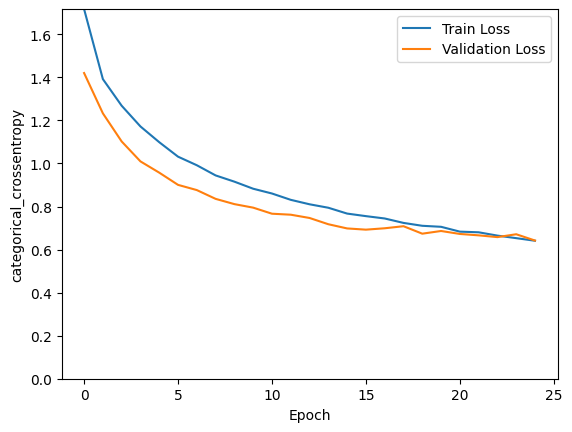

In [ ]:
# Entrenar el modelo con los datos preparados previamente
history = model.fit(data_train,
          epochs=25,   # número de epochs
          verbose=1,  # muestra información al finalizar cada epoch
          steps_per_epoch=len(x_train)*(1-val_split)/batch_size,
          validation_data=data_dev,
          validation_steps=len(x_train)*val_split/batch_size)

plot_history(history)

### **4. Evaluar una CNN**

Hemos visto cómo crear y entrenar una CNN desde cero, utilizando una configuración de hiperparámetros que no necesariamente es la mejor. Lo ideal sería realizar una búsqueda de hiperparámetros y, una vez obtenida la mejor configuración, evaluar el modelo sobre el conjunto de test y así obtener el resultado final.

A continuación, se muestra el código para evaluar el modelo final en el conjunto de test. Para ello utilizaremos el método [`evaluate()`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#evaluate) que necesita que le suministremos los datos de test y el tamaño del *batch* (para calcular el número de `steps`).


In [ ]:
# Evaluar el modelo en el conjunto de test
test_loss, test_acc = model.evaluate(data_test,
                                     steps=len(x_test)/batch_size,
                                     verbose=1)
print("test_loss: %.4f, test_acc: %.4f" % (test_loss, test_acc))

78/78 [==============================] - 1s 12ms/step - loss: 0.6462 - accuracy: 0.7775
test_loss: 0.6462, test_acc: 0.7775


### **5. Pruebas**

Realiza una serie de pruebas con diferentes configuraciones de hiperparámetros (tasa de aprendizaje, optimizador) e intenta mejorar los resultados. Prueba también a definir tu propia arquitectura, utilizando otra secuencia de capas.

Para generar nuevos ejemplos de entrenamiento utilizando diferentes técnicas de *data augmentation*, puedes utilizar otros parámetros del método [`ImageDataGenerator()`](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator).

Por último, se recomienda utilizar técnicas que ayudan a prevenir el sobreajuste. Prueba a añadir capas de Dropout en tu modelo, típicamente después de las capas *pooling*, utilizando para ello distintos valores del parámetro `rate`.

*   [Capa dropout](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout): *Dropout(rate)* pone a 0, aleatoriamente, las entradas con una frecuencia de `rate` (número real entre 0 y 1) en cada paso del proceso de entrenamiento, reduciendo así el sobreajuste.

# 6. Comentarios de clase
- MaxPooling, AveragePooling, etc solo cambia la manera que tiene de hacer el pooling.
- steps_per_batch depende del tamaño del batch y del número de datos que se tienen y se tiene que saber calcular.
